In [23]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
from mlp import MLP1, MLP2, encode_data, fix_random_seed
from collections import defaultdict

plt.style.use({'figure.facecolor':'white'})

In [24]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [25]:
model_path_1 = './model/haoran_mbd2/cliffords_and_mbd2.pth'
# model_path_1 = './model/haoran_mbd2/random_cliffords.pth'
# model_path_2 = './model/haoran_mbd2/random_circuits.pth'
# model_path_3 = './model/haoran_mbd2/random_brickwork4.pth'
# model_path_4 = './model/haoran_mbd2/mbd.pth'
model_path_5 = './model/haoran_mbd2/mlp2_cliffords_and_mbd2.pth'
# model_path_5 = './model/haoran_mbd2/mlp_random_cliffords.pth'
# model_path_6 = './model/haoran_mbd2/mlp_random_brickwork.pth'
# model_path_7 = './model/haoran_mbd2/mlp_mbd.pth'

In [26]:
models = []

model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

# model_2 = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15
# )
# model_2.load_state_dict(torch.load(model_path_2), strict=True)
# model_2.eval()
# models.append(model_2)

# model_3 = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15
# )
# model_3.load_state_dict(torch.load(model_path_3), strict=True)
# model_3.eval()
# models.append(model_3)

# model_4 = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15
# )
# model_4.load_state_dict(torch.load(model_path_4), strict=True)
# model_4.eval()
# models.append(model_4)

model_5 = MLP2(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_5.load_state_dict(torch.load(model_path_5), strict=True)
model_5.eval()
models.append((model_5, 'mlp'))

# model_6 = MLP1(
#     input_size=58,
#     output_size=4,
#     hidden_size=128
# )
# model_6.load_state_dict(torch.load(model_path_6), strict=True)
# model_6.eval()
# models.append(model_6)
#
# model_7 = MLP1(
#     input_size=58,
#     output_size=4,
#     hidden_size=128
# )
# model_7.load_state_dict(torch.load(model_path_7), strict=True)
# model_7.eval()
# models.append(model_7)

In [29]:
fix_random_seed(0)

max_steps = 10

num_disorders = 30
num_spins = 4
W = 0.8 * np.pi
theta = 0.05 * np.pi
even_qubits = np.linspace(0, num_spins, int(num_spins / 2), endpoint=False)
odd_qubits = np.linspace(1, num_spins + 1, int(num_spins / 2), endpoint=False)

def run_mbd_floquet_steps():
    imbalance_all_ideal = []
    imbalance_all_noisy = []
    imbalance_all_mitigated_dict = defaultdict(list)

    exp_Z_all_ideal = []
    exp_Z_all_noisy = []
    exp_Z_all_mitigated_dict = defaultdict(list)

    for disorder_realization in tqdm_notebook(range(num_disorders)):
        disorders = generate_disorder(num_spins, W, seed=disorder_realization)

        qc_list = []
        for steps in range(max_steps + 30):
            qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

        transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
        job_ideal = execute(qc_list, **run_config_ideal)
        job_noisy = execute(transpiled_qc_list, **run_config_noisy)

        exp_Z_ideal = []
        exp_Z_noisy = []
        exp_Z_mitigated_dict = defaultdict(list)

        for i in range(len(qc_list)):
            counts_ideal = job_ideal.result().get_counts()[i]
            counts_noisy = job_noisy.result().get_counts()[i]

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            exp_Z_ideal.append(list(ideal_exp_val))  # Single-Z expectation value of each qubit
            exp_Z_noisy.append(list(noisy_exp_val))  # Single-Z expectation value of each qubit

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled_qc_list[i],
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=transpiled_qc_list[i].depth()
            ).to_pyg_data()

            X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

            for j, (model, type) in enumerate(models):
                if type == 'mlp':
                    mitigated_exp_val = model(X).tolist()[0]
                elif type == 'gnn':
                    mitigated_exp_val = model(entry.noisy_0,
                                            entry.observable,
                                            entry.circuit_depth,
                                            entry.x,
                                            entry.edge_index,
                                            entry.batch).tolist()[0]
                else:
                    raise NotImplementedError

                exp_Z_mitigated_dict[j].append(mitigated_exp_val)

        imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
        imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
        imbalance_mitigated_dict = defaultdict(list)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            imbalance_mitigated_dict[k] = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

        imbalance_all_ideal.append(imbalance_ideal)
        imbalance_all_noisy.append(imbalance_noisy)
        for k, imbalance_mitigated in imbalance_mitigated_dict.items():
            imbalance_all_mitigated_dict[k].append(imbalance_mitigated)

        exp_Z_all_ideal.append(exp_Z_ideal)
        exp_Z_all_noisy.append(exp_Z_noisy)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            exp_Z_all_mitigated_dict[k].append(exp_Z_mitigated)

    # Average imbalance
    imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
    imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
    imbalance_mitigated_average_dict = defaultdict()
    for ind, imbalance_all_mitigated in imbalance_all_mitigated_dict.items():
        imbalance_mitigated_average_dict[ind] = np.mean(imbalance_all_mitigated, axis=0)

    return imbalance_ideal_average, imbalance_noisy_average, imbalance_mitigated_average_dict

mbd_imb_ideal, mbd_imb_noisy, mbd_imb_mitigated = run_mbd_floquet_steps()

random seed fixed to 0


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# """Save all charge imbalance"""
# to_save = {
#     'exp_Z_ideal': exp_Z_all_ideal,
#     'exp_Z_noisy': exp_Z_all_noisy,
#     'exp_Z_mitigated_rand_cliff': exp_Z_all_mitigated_1,
#     'exp_Z_mitigated_rand_circ': exp_Z_all_mitigated_2,
#     'exp_Z_mitigated_rand_brick': exp_Z_all_mitigated_3,
#     'exp_Z_mitigated_mbd': exp_Z_all_mitigated_4,
#
#     'ideal_average': list(imbalance_ideal_average),
#     'noisy_average': list(imbalance_noisy_average),
#     'mitigated_average_random_cliff': list(imbalance_mitigated_average_1),
#     'mitigated_average_random_circ': list(imbalance_mitigated_average_2),
#     'mitigated_average_random_brick': list(imbalance_mitigated_average_3),
#     'mitigated_average_mbd': list(imbalance_mitigated_average_4)
# }
#
# with open('./results_to_plot/mbd/charge_imbal_at_steps.json', 'w') as f:
#     json.dump(to_save, f)

In [ ]:
# with open('./single_z_exp_at_steps.json', 'r') as f:
#     d = json.load(f)

# for key, val in d.items():
#     print(key, '\n', np.mean(np.array(val)[:, 0], 0))

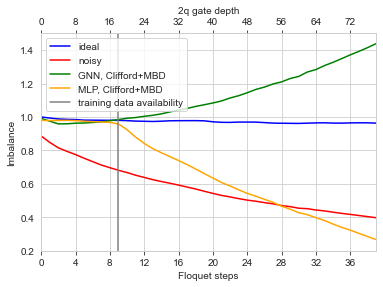

In [35]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(mbd_imb_ideal, color='blue', label="ideal")
ax1.plot(mbd_imb_noisy, color='red', label="noisy")
colors = ['green', 'orange']
labels = ["GNN, Clifford+MBD",
          "MLP, Clifford+MBD",]
ls = ['solid', 'solid']
for i in range(len(mbd_imb_mitigated)):
    ax1.plot(mbd_imb_mitigated[i], color=colors[i], label=labels[i], linestyle=ls[i])

ax1.axvline(x = 9, color = 'gray', label = 'training data availability')

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

xmin, xmax = ax1.get_xlim()
max_x = max_steps + 30
ax1.set_xlim([0, max_x-1])
ax2.set_xlim([0, max_x-1])
ax1.set_ylim([0.2, 1.5])
ax1.set_xticks(np.arange(0, max_x, 4))
x2 = np.linspace(xmin, xmax, 50)
ax2.plot(x2, -np.ones(50)) # Create a dummy plot
ax2.set_xticks(np.arange(0, max_x, 4))
ax2.set_xticklabels(2*np.arange(0, max_x, 4))
ax2.set_xlabel(r"2q gate depth")
# ax1.grid(None)
ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()